**Assignment Objective:**

Consider the QWorld environment from your first assignment. The objective of this assignment is to design a agent that learn how to solve this problem through the **sarsamax (Q-learning)** and **sarsa** algorithms seen in class

Provide your answers for **PART1** and **PART2** in this notebook and submit it before the due date.

In [51]:
"""Q Learning to solve a simple world model

Simple deterministic MDP is made of 6 grids (states)
---------------------------------
|         |          |          |
|  Start  |          |  Goal    |
|         |          |          |
---------------------------------
|         |          |          |
|         |          |  Hole    |
|         |          |          |
---------------------------------

"""

from collections import deque
import numpy as np
import argparse
import os
import time
from termcolor import colored


class QWorld:
    def __init__(self):
        """Simulated deterministic world made of 6 states.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = 4

        # 6 states
        self.row = 6

        # setup the environment
        self.init_transition_table()
        self.init_reward_table()

        # reset the environment
        self.reset()

    def reset(self):
        """start of episode"""
        self.state = 0
        self.count = 0
        return self.state

    def is_in_win_state(self):
        """agent wins when the goal is reached"""
        return self.state == 2


    def init_reward_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        ----------------
        | 0 | 0 | 100  |
        ----------------
        | 0 | 0 | -100 |
        ----------------
        """
        #reward_table[state,action]=reward
        
        self.reward_table = np.zeros([self.row, self.col])
        self.reward_table[1, 2] = 100.
        self.reward_table[4, 2] = -100.


    def init_transition_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        -------------
        | 0 | 1 | 2 |
        -------------
        | 3 | 4 | 5 |
        -------------
        """
        self.transition_table = np.zeros([self.row, self.col],
                                         dtype=int)
        #transition_table[state,action]=new_state
        self.transition_table[0, 0] = 0
        self.transition_table[0, 1] = 3
        self.transition_table[0, 2] = 1
        self.transition_table[0, 3] = 0

        self.transition_table[1, 0] = 0
        self.transition_table[1, 1] = 4
        self.transition_table[1, 2] = 2
        self.transition_table[1, 3] = 1

        # terminal Goal state
        self.transition_table[2, 0] = 2
        self.transition_table[2, 1] = 2
        self.transition_table[2, 2] = 2
        self.transition_table[2, 3] = 2

        self.transition_table[3, 0] = 3
        self.transition_table[3, 1] = 3
        self.transition_table[3, 2] = 4
        self.transition_table[3, 3] = 0

        self.transition_table[4, 0] = 3
        self.transition_table[4, 1] = 4
        self.transition_table[4, 2] = 5
        self.transition_table[4, 3] = 1

        # terminal Hole state
        self.transition_table[5, 0] = 5
        self.transition_table[5, 1] = 5
        self.transition_table[5, 2] = 5
        self.transition_table[5, 3] = 5


    def step(self, action):
        """execute the action on the environment
        Argument:
            action (tensor): An action in Action space
        Returns:
            next_state (tensor): next env state
            reward (float): reward received by the agent
            done (Bool): whether the terminal state
                is reached
        """
        # determine the next_state given state and action
        next_state = self.transition_table[self.state, action]
        # done is True if next_state is Goal or Hole
        done = next_state == 2 or next_state == 5
        # reward given the state and action
        reward = self.reward_table[self.state, action]
        # the enviroment is now in new state
        self.state = next_state
        self.count+=1
        return next_state, reward, done




    def print_cell(self, row=0):
        """UI to display agent moving on the grid"""
        print("")
        for i in range(13):
            j = i - 2
            if j in [0, 4, 8]:
                if j == 8:
                    if self.state == 2 and row == 0:
                        marker = "\033[4mG\033[0m"
                    elif self.state == 5 and row == 1:
                        marker = "\033[4mH\033[0m"
                    else:
                        marker = 'G' if row == 0 else 'H'
                    color = self.state == 2 and row == 0
                    color = color or (self.state == 5 and row == 1)
                    color = 'red' if color else 'blue'
                    print(colored(marker, color), end='')
                elif self.state in [0, 1, 3, 4]:
                    cell = [(0, 0, 0), (1, 0, 4), (3, 1, 0), (4, 1, 4)]
                    marker = '_' if (self.state, row, j) in cell else ' '
                    print(colored(marker, 'red'), end='')
                else:
                    print(' ', end='')
            elif i % 4 == 0:
                    print('|', end='')
            else:
                print(' ', end='')
        print("")


    def print_world(self, action, step,is_explore):
        """UI to display mode and action of agent"""
        actions = { 0: "(Left)", 1: "(Down)", 2: "(Right)", 3: "(Up)" }
        explore = "Explore" if is_explore else "Exploit"
        print("Step", step, ":", explore, actions[action])
        for _ in range(13):
            print('-', end='')
        self.print_cell()
        for _ in range(13):
            print('-', end='')
        self.print_cell(row=1)
        for _ in range(13):
            print('-', end='')
        print("")




In [52]:
def print_episode(episode, delay=1):
    """UI to display episode count
    Arguments:
        episode (int): episode number
        delay (int): sec delay

    """
    os.system('clear')
    for _ in range(13):
        print('=', end='')
    print("")
    print("Episode ", episode)
    for _ in range(13):
        print('=', end='')
    print("")
    time.sleep(delay)


def print_status(q_world,q_agent, done, step, delay=1):
    """UI to display the world,
        delay of 1 sec for ease of understanding
    """
    os.system('clear')
    q_world.print_world(action, step,q_agent.is_explore)
    q_agent.print_q_table()
    if done:
        print("-------EPISODE DONE--------")
        delay *= 2
    time.sleep(delay)

# **PART1**: SARSAMAX agent (off-policy)


## a) complete the TODO parts in the cell below in order to design an agent that learns through Q-learning

In [53]:
class QAgent:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            ##################################################
            #TODO set exploration mode to true and
            # take random action
            self.is_explore=True
            action = np.random.choice(range(4))
            ##################################################

        else:
            ##################################################
            #TODO set exploration mode to false and
            # take greedy action
            self.is_explore=False
            action = np.argmax(self.q_table[state])
            ##################################################


        return action

    def update_q_table(self, state, action, reward, next_state):
        """Q-Learning - update the Q Table using Q(s, a)
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
        ########################################################
        #TODO update the Q-table with blended Bellman update rule
        #Q(st,at) : Current_Q_Value
        Current_Q_Value = self.q_table[state, action]
        #max(Q(st+1,at)) :Max_Next_Q_Value
        Max_Next_Q_Value = np.max(self.q_table[next_state])
        New_Q_Value = (1 - self.alpha) * Current_Q_Value + self.alpha * (reward + self.gamma * Max_Next_Q_Value)
        self.q_table[state, action] =  New_Q_Value

        ########################################################

    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



## b) complete the TODO parts in the cell below order to implement a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [54]:
delay = 0
wins = 0
episode_count = 10000
iteration_list1 = []
percent_wins_list1 = []
q_world = QWorld()
q_agent = QAgent(col=q_world.col, row=q_world.row, alpha=0.1)
iterations = 0
np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    is_explore=True
    print_episode(episode, delay=delay)
    while not done:
      # todo: Obtain  next_state, reward, done  from the environment.
        action = q_agent.act(state)
        next_state, reward, done = q_world.step(action)

        # todo: update the q-table.
        q_agent.update_q_table(state, action, reward, next_state)

        # todo: update state: the current state becomes the next_state in the next iteration

        state = next_state

        iterations += 1


        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

            q_agent.update_epsilon()
            iteration_list1.append(iterations)
            percent_wins_list1.append(percent_wins)



    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------0.00% Goals in 1 Episodes---------
Episode  2
-------33.33% Goals in 2 Episodes---------
Episode  3
-------50.00% Goals in 3 Episodes---------
Episode  4
-------60.00% Goals in 4 Episodes---------
Episode  5
-------66.67% Goals in 5 Episodes---------
Episode  6
-------71.43% Goals in 6 Episodes---------
Episode  7
-------75.00% Goals in 7 Episodes---------
Episode  8
-------77.78% Goals in 8 Episodes---------
Episode  9
-------80.00% Goals in 9 Episodes---------
Episode  10
-------81.82% Goals in 10 Episodes---------
Episode  11
-------75.00% Goals in 11 Episodes---------
Episode  12
-------76.92% Goals in 12 Episodes---------
Episode  13
-------78.57% Goals in 13 Episodes---------
Episode  14
-------80.00% Goals in 14 Episodes---------
Episode  15
-------81.25% Goals in 15 Episodes---------
Episode  16
-------82.35% Goals in 16 Episodes---------
Episode  17
-------83.33% Goals in 17 Episodes---------
Episode  18
--

Episode  112
-------97.35% Goals in 112 Episodes---------
Episode  113
-------97.37% Goals in 113 Episodes---------
Episode  114
-------97.39% Goals in 114 Episodes---------
Episode  115
-------97.41% Goals in 115 Episodes---------
Episode  116
-------97.44% Goals in 116 Episodes---------
Episode  117
-------97.46% Goals in 117 Episodes---------
Episode  118
-------97.48% Goals in 118 Episodes---------
Episode  119
-------97.50% Goals in 119 Episodes---------
Episode  120
-------97.52% Goals in 120 Episodes---------
Episode  121
-------97.54% Goals in 121 Episodes---------
Episode  122
-------97.56% Goals in 122 Episodes---------
Episode  123
-------97.58% Goals in 123 Episodes---------
Episode  124
-------97.60% Goals in 124 Episodes---------
Episode  125
-------97.62% Goals in 125 Episodes---------
Episode  126
-------97.64% Goals in 126 Episodes---------
Episode  127
-------97.66% Goals in 127 Episodes---------
Episode  128
-------97.67% Goals in 128 Episodes---------
Episode  129
-

Episode  222
-------98.65% Goals in 222 Episodes---------
Episode  223
-------98.66% Goals in 223 Episodes---------
Episode  224
-------98.67% Goals in 224 Episodes---------
Episode  225
-------98.67% Goals in 225 Episodes---------
Episode  226
-------98.68% Goals in 226 Episodes---------
Episode  227
-------98.68% Goals in 227 Episodes---------
Episode  228
-------98.69% Goals in 228 Episodes---------
Episode  229
-------98.70% Goals in 229 Episodes---------
Episode  230
-------98.70% Goals in 230 Episodes---------
Episode  231
-------98.71% Goals in 231 Episodes---------
Episode  232
-------98.71% Goals in 232 Episodes---------
Episode  233
-------98.72% Goals in 233 Episodes---------
Episode  234
-------98.72% Goals in 234 Episodes---------
Episode  235
-------98.73% Goals in 235 Episodes---------
Episode  236
-------98.73% Goals in 236 Episodes---------
Episode  237
-------98.74% Goals in 237 Episodes---------
Episode  238
-------98.74% Goals in 238 Episodes---------
Episode  239
-

Episode  321
-------99.07% Goals in 321 Episodes---------
Episode  322
-------99.07% Goals in 322 Episodes---------
Episode  323
-------99.07% Goals in 323 Episodes---------
Episode  324
-------99.08% Goals in 324 Episodes---------
Episode  325
-------99.08% Goals in 325 Episodes---------
Episode  326
-------99.08% Goals in 326 Episodes---------
Episode  327
-------99.09% Goals in 327 Episodes---------
Episode  328
-------99.09% Goals in 328 Episodes---------
Episode  329
-------99.09% Goals in 329 Episodes---------
Episode  330
-------99.09% Goals in 330 Episodes---------
Episode  331
-------99.10% Goals in 331 Episodes---------
Episode  332
-------99.10% Goals in 332 Episodes---------
Episode  333
-------99.10% Goals in 333 Episodes---------
Episode  334
-------99.10% Goals in 334 Episodes---------
Episode  335
-------99.11% Goals in 335 Episodes---------
Episode  336
-------99.11% Goals in 336 Episodes---------
Episode  337
-------99.11% Goals in 337 Episodes---------
Episode  338
-

Episode  432
-------99.31% Goals in 432 Episodes---------
Episode  433
-------99.31% Goals in 433 Episodes---------
Episode  434
-------99.31% Goals in 434 Episodes---------
Episode  435
-------99.31% Goals in 435 Episodes---------
Episode  436
-------99.31% Goals in 436 Episodes---------
Episode  437
-------99.32% Goals in 437 Episodes---------
Episode  438
-------99.32% Goals in 438 Episodes---------
Episode  439
-------99.32% Goals in 439 Episodes---------
Episode  440
-------99.32% Goals in 440 Episodes---------
Episode  441
-------99.32% Goals in 441 Episodes---------
Episode  442
-------99.32% Goals in 442 Episodes---------
Episode  443
-------99.32% Goals in 443 Episodes---------
Episode  444
-------99.33% Goals in 444 Episodes---------
Episode  445
-------99.33% Goals in 445 Episodes---------
Episode  446
-------99.33% Goals in 446 Episodes---------
Episode  447
-------99.33% Goals in 447 Episodes---------
Episode  448
-------99.33% Goals in 448 Episodes---------
Episode  449
-

Episode  543
-------99.45% Goals in 543 Episodes---------
Episode  544
-------99.45% Goals in 544 Episodes---------
Episode  545
-------99.45% Goals in 545 Episodes---------
Episode  546
-------99.45% Goals in 546 Episodes---------
Episode  547
-------99.45% Goals in 547 Episodes---------
Episode  548
-------99.45% Goals in 548 Episodes---------
Episode  549
-------99.45% Goals in 549 Episodes---------
Episode  550
-------99.46% Goals in 550 Episodes---------
Episode  551
-------99.46% Goals in 551 Episodes---------
Episode  552
-------99.46% Goals in 552 Episodes---------
Episode  553
-------99.46% Goals in 553 Episodes---------
Episode  554
-------99.46% Goals in 554 Episodes---------
Episode  555
-------99.46% Goals in 555 Episodes---------
Episode  556
-------99.46% Goals in 556 Episodes---------
Episode  557
-------99.46% Goals in 557 Episodes---------
Episode  558
-------99.46% Goals in 558 Episodes---------
Episode  559
-------99.46% Goals in 559 Episodes---------
Episode  560
-

### c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?
### **(indicate answer in text cell  here)**

Answer : The problem is considered solved when 99.50% of the goals have been achieved and after 1289 iterations.

### d) Provide a plot of the percent_wins as a function of the iterations (i.e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

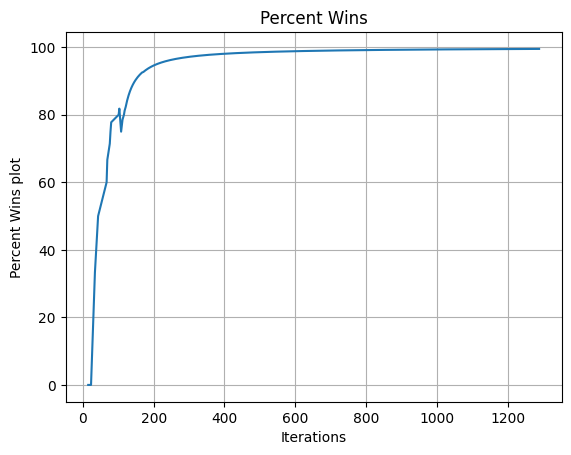

In [55]:
#a plot of the percent_wins as a function of the iterations 
import matplotlib.pyplot as plt
plt.plot(iteration_list1, percent_wins_list1)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins plot')
plt.title('Percent Wins')
plt.grid(True)
plt.show()

### e) Print the final Q-table (after training loop ends)

In [56]:
#Final Q-table after training loop ends
q_agent.print_q_table()

Q-Table (Epsilon: 0.00)
[[  0.600777     0.          90.           0.        ]
 [  0.600777     2.54337213 100.          16.13991943]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.351459     0.        ]
 [  0.           0.351459   -27.1         21.02568763]
 [  0.           0.           0.           0.        ]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?
### **(add answer in text cell here)**

Answer : state = 3 ==> Q(s=3,a) is in [0,0,0.351459,0] ==> choosing the max value witch is equal to 0.351459 ==> the best action to take is action 2 witch is right


### g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

In [57]:
Episodes1 = []
Reached_Goals1= []
# Run 20 episodes with full exploitation
for episode in range(20):
    state = q_world.reset()
    done = False
    goal_reached = False
    is_explore = False

    while not done:
        action = q_agent.act(state)
        next_state, _, done = q_world.step(action)
        if done and q_world.is_in_win_state():
            goal_reached = True

        state = next_state

    print("Episode %d - Goal Reached: %s" % (episode, "Yes" if goal_reached else "No"))

    Episodes1.append(episode)
    Reached_Goals1.append(1 if goal_reached else 0)



Episode 0 - Goal Reached: Yes
Episode 1 - Goal Reached: Yes
Episode 2 - Goal Reached: Yes
Episode 3 - Goal Reached: Yes
Episode 4 - Goal Reached: Yes
Episode 5 - Goal Reached: Yes
Episode 6 - Goal Reached: Yes
Episode 7 - Goal Reached: Yes
Episode 8 - Goal Reached: Yes
Episode 9 - Goal Reached: Yes
Episode 10 - Goal Reached: Yes
Episode 11 - Goal Reached: Yes
Episode 12 - Goal Reached: Yes
Episode 13 - Goal Reached: Yes
Episode 14 - Goal Reached: Yes
Episode 15 - Goal Reached: Yes
Episode 16 - Goal Reached: Yes
Episode 17 - Goal Reached: Yes
Episode 18 - Goal Reached: Yes
Episode 19 - Goal Reached: Yes


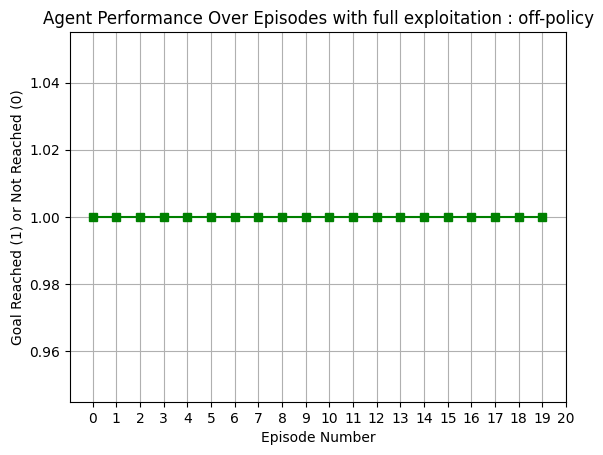

In [58]:
plt.plot(Episodes1, Reached_Goals1, marker='s', linestyle='-', color='green')  
plt.title('Agent Performance Over Episodes with full exploitation : off-policy')
plt.xlabel('Episode Number')
plt.ylabel('Goal Reached (1) or Not Reached (0)')
plt.xticks(range(0, 21)) 
plt.grid(True)
plt.show()


In [59]:
percent_wins_20_episodes = sum(Reached_Goals1) / len( Reached_Goals1) * 100
print("Percent Wins for 20 Episodes: %0.2f%%" % percent_wins_20_episodes)

Percent Wins for 20 Episodes: 100.00%


# **PART2**: SARSA-based agent (ON-policy)
# In this part, you need to implement an agent that learns how to solve this problem with the on-policy sarsa algorithm. Re-answer all the questions as in part A):  from a) to g)

# a) complete the TODO parts in the cell below in order to design an agent that learns through Q-learning

In [60]:
class QAgent_Onpolicy:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            self.is_explore = True
            action = np.random.choice(range(4))

        else:
            self.is_explore = False
            action = np.argmax(self.q_table[state])

        return action

    #update_qtable function for on-policy
    def update_q_table(self, state, action, reward, next_state, next_action):
        #Q(st,at)<=Q(st,at)+alpha*(Rt+1 + gamma*Q(st+1,at+1)-Q(st,at))
        #Q(st,at): current_value
        current_value = self.q_table[state, action]
        #Q(st+1,at+1) : next_value
        next_value = self.q_table[next_state, next_action]
        target = reward + self.gamma * next_value
        new_value = current_value + self.alpha * (target - current_value)
        self.q_table[state, action] = new_value


    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# ## b) complete the TODO parts in the cell below order to implement a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update for the on-policy 
4. Check convergence conditions. If not met, repeat from step 2.

In [61]:
delay = 0
wins = 0
episode_count = 10000
iteration_list2 = []
percent_wins_list2 = []
q_world = QWorld()
q_agent = QAgent_Onpolicy(col=q_world.col, row=q_world.row, alpha=0.1)
iterations = 0

np.random.seed(5)
for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    is_explore=True
    action = q_agent.act(state)
    while not done:
      # todo: Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)
        next_action=q_agent.act(next_state)
        # todo: update the q-table.
        q_agent.update_q_table(state, action, reward, next_state,next_action)

        # todo: update state: the current state becomes the next_state in the next iteration

        state = next_state
        action=next_action

        iterations += 1


        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

            q_agent.update_epsilon()
            iteration_list2.append(iterations)
            percent_wins_list2.append(percent_wins)



    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------0.00% Goals in 1 Episodes---------
Episode  2
-------33.33% Goals in 2 Episodes---------
Episode  3
-------50.00% Goals in 3 Episodes---------
Episode  4
-------60.00% Goals in 4 Episodes---------
Episode  5
-------66.67% Goals in 5 Episodes---------
Episode  6
-------71.43% Goals in 6 Episodes---------
Episode  7
-------75.00% Goals in 7 Episodes---------
Episode  8
-------77.78% Goals in 8 Episodes---------
Episode  9
-------80.00% Goals in 9 Episodes---------
Episode  10
-------81.82% Goals in 10 Episodes---------
Episode  11
-------83.33% Goals in 11 Episodes---------
Episode  12
-------84.62% Goals in 12 Episodes---------
Episode  13
-------85.71% Goals in 13 Episodes---------
Episode  14
-------86.67% Goals in 14 Episodes---------
Episode  15
-------87.50% Goals in 15 Episodes---------
Episode  16
-------88.24% Goals in 16 Episodes---------
Episode  17
-------88.89% Goals in 17 Episodes---------
Episode  18
--

Episode  111
-------98.21% Goals in 111 Episodes---------
Episode  112
-------98.23% Goals in 112 Episodes---------
Episode  113
-------98.25% Goals in 113 Episodes---------
Episode  114
-------98.26% Goals in 114 Episodes---------
Episode  115
-------98.28% Goals in 115 Episodes---------
Episode  116
-------98.29% Goals in 116 Episodes---------
Episode  117
-------98.31% Goals in 117 Episodes---------
Episode  118
-------98.32% Goals in 118 Episodes---------
Episode  119
-------98.33% Goals in 119 Episodes---------
Episode  120
-------98.35% Goals in 120 Episodes---------
Episode  121
-------98.36% Goals in 121 Episodes---------
Episode  122
-------98.37% Goals in 122 Episodes---------
Episode  123
-------98.39% Goals in 123 Episodes---------
Episode  124
-------98.40% Goals in 124 Episodes---------
Episode  125
-------98.41% Goals in 125 Episodes---------
Episode  126
-------98.43% Goals in 126 Episodes---------
Episode  127
-------98.44% Goals in 127 Episodes---------
Episode  128
-

Episode  221
-------99.10% Goals in 221 Episodes---------
Episode  222
-------99.10% Goals in 222 Episodes---------
Episode  223
-------99.11% Goals in 223 Episodes---------
Episode  224
-------99.11% Goals in 224 Episodes---------
Episode  225
-------99.12% Goals in 225 Episodes---------
Episode  226
-------99.12% Goals in 226 Episodes---------
Episode  227
-------99.12% Goals in 227 Episodes---------
Episode  228
-------99.13% Goals in 228 Episodes---------
Episode  229
-------99.13% Goals in 229 Episodes---------
Episode  230
-------99.13% Goals in 230 Episodes---------
Episode  231
-------99.14% Goals in 231 Episodes---------
Episode  232
-------99.14% Goals in 232 Episodes---------
Episode  233
-------99.15% Goals in 233 Episodes---------
Episode  234
-------99.15% Goals in 234 Episodes---------
Episode  235
-------99.15% Goals in 235 Episodes---------
Episode  236
-------99.16% Goals in 236 Episodes---------
Episode  237
-------99.16% Goals in 237 Episodes---------
Episode  238
-

Episode  333
-------99.40% Goals in 333 Episodes---------
Episode  334
-------99.40% Goals in 334 Episodes---------
Episode  335
-------99.40% Goals in 335 Episodes---------
Episode  336
-------99.41% Goals in 336 Episodes---------
Episode  337
-------99.41% Goals in 337 Episodes---------
Episode  338
-------99.41% Goals in 338 Episodes---------
Episode  339
-------99.41% Goals in 339 Episodes---------
Episode  340
-------99.41% Goals in 340 Episodes---------
Episode  341
-------99.42% Goals in 341 Episodes---------
Episode  342
-------99.42% Goals in 342 Episodes---------
Episode  343
-------99.42% Goals in 343 Episodes---------
Episode  344
-------99.42% Goals in 344 Episodes---------
Episode  345
-------99.42% Goals in 345 Episodes---------
Episode  346
-------99.42% Goals in 346 Episodes---------
Episode  347
-------99.43% Goals in 347 Episodes---------
Episode  348
-------99.43% Goals in 348 Episodes---------
Episode  349
-------99.43% Goals in 349 Episodes---------
Episode  350
-

# c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?
### **(indicate answer in text cell  here)**


Answer : The problem is considered solved when 99.50% of the goals have been achieved and after 884 iterations.

### d) Provide a plot of the percent_wins as a function of the iterations (i.e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

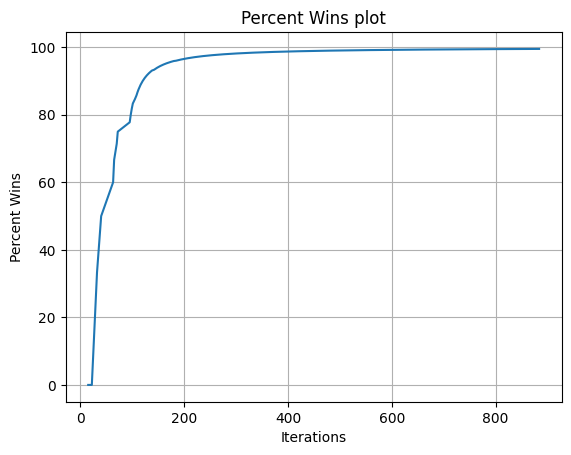

In [62]:
plt.plot(iteration_list2, percent_wins_list2)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins')
plt.title('Percent Wins plot')
plt.grid(True)
plt.show()

### e) Print the final Q-table (after training loop ends)

In [63]:
#the fianl q_table
q_agent.print_q_table()

Q-Table (Epsilon: 0.00)
[[ 3.22218000e-01  5.38409511e-02  9.00000000e+01  0.00000000e+00]
 [ 0.00000000e+00  1.24759975e-01  1.00000000e+02  6.17570464e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.07698220e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.90000000e+01  2.49782000e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?
### **(add answer in text cell here)**

Answer : state = 3 ==> Q(s=3,a) is in [0,0,0,0] ==> choosing the max value witch is equal to 0.351459 ==> all actions are equal we can choose any one

### g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

In [64]:
Episodes2 = []
Reached_Goals2= []
# Run 20 episodes with full exploitation
for episode in range(20):
    state = q_world.reset()
    done = False
    goal_reached = False
    is_explore = False

    while not done:
        action = q_agent.act(state)
        next_state, _, done = q_world.step(action)
        if done and q_world.is_in_win_state():
            goal_reached = True

        state = next_state

    print("Episode %d - Goal Reached: %s" % (episode, "Yes" if goal_reached else "No"))

    Episodes2.append(episode)
    Reached_Goals2.append(1 if goal_reached else 0)



Episode 0 - Goal Reached: Yes
Episode 1 - Goal Reached: Yes
Episode 2 - Goal Reached: Yes
Episode 3 - Goal Reached: Yes
Episode 4 - Goal Reached: Yes
Episode 5 - Goal Reached: Yes
Episode 6 - Goal Reached: Yes
Episode 7 - Goal Reached: Yes
Episode 8 - Goal Reached: Yes
Episode 9 - Goal Reached: Yes
Episode 10 - Goal Reached: Yes
Episode 11 - Goal Reached: Yes
Episode 12 - Goal Reached: Yes
Episode 13 - Goal Reached: Yes
Episode 14 - Goal Reached: Yes
Episode 15 - Goal Reached: Yes
Episode 16 - Goal Reached: Yes
Episode 17 - Goal Reached: Yes
Episode 18 - Goal Reached: Yes
Episode 19 - Goal Reached: Yes


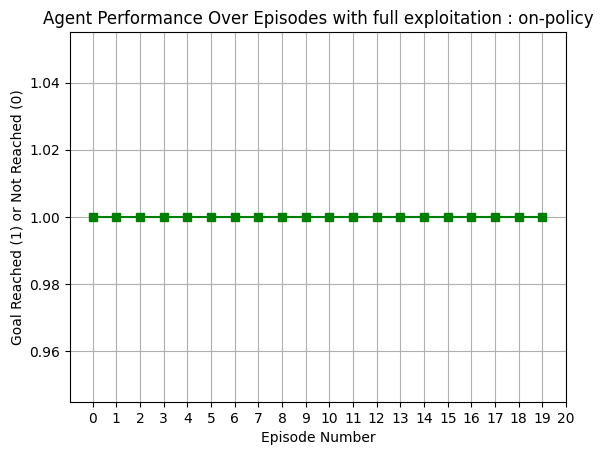

In [65]:
plt.plot(Episodes2, Reached_Goals2, marker='s', linestyle='-', color='green')  
plt.title('Agent Performance Over Episodes with full exploitation : on-policy')
plt.xlabel('Episode Number')
plt.ylabel('Goal Reached (1) or Not Reached (0)')
plt.xticks(range(0, 21)) 
plt.grid(True)
plt.show()


In [66]:
percent_wins_20_episodes = sum(Reached_Goals2) / len( Reached_Goals2) * 100
print("Percent Wins for 20 Episodes: %0.2f%%" % percent_wins_20_episodes)

Percent Wins for 20 Episodes: 100.00%
